# Analysis of excitonic states

In [1]:
%autosave 0
from BigDFT import Logfiles as lf
from BigDFT import Calculators as C
from futile import Yaml
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
import sys
sys.path.insert(0,'../')
import Routine as R
outputpath = 'linear-response/'

Autosave disabled


We read the coupling matrix and dipoles (with the highest given number of virtual orbitals)

In [2]:
rmult = 9.0 # 9.0

%cd $outputpath
if rmult == 7.0:
    nVirtMax = 303
    dpath = 'log/TDDFT-Results/transition_dipoles_'+str(nVirtMax)+'.txt'
    cpath = 'log/TDDFT-Results/coupling_matrix_'+str(nVirtMax)+'.txt'
    logpath = 'log/log-NumVirt_'+str(nVirtMax)+'.yaml'
    log = !ls $logpath
    print log
if rmult == 9.0:
    nVirtMax = 279
    dpath = 'log/TDDFT-Results/transition_dipoles_rmult=9.0_'+str(nVirtMax)+'.txt'
    cpath = 'log/TDDFT-Results/coupling_matrix_rmult=9.0_'+str(nVirtMax)+'.txt'
    logpath = 'log/log-NumVirt_'+str(nVirtMax)+'.yaml'
    log = !ls $logpath

dipoles = np.loadtxt(dpath)
Cmat = np.loadtxt(cpath)
Data = lf.Logfile(log[0])
%cd ..
Cmat.shape

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/linear-response
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


(2790, 2790)

We set the number of empty and virtual states and build the C submatrix with the chosen values of nalpha

In [3]:
numOrb = 5
nalpha = [32,64,128,192,256,nVirtMax]

We define a routine that computes the maximum energy corresponding to each choice of nalpha

In [4]:
reload(R)
R.engMax(Data,numOrb,64)

8.8989781346906742

We compute the eigenvalues and vectors of C_ext (linalg.eigh gives the eigenvectors in the transpose form so we peform an explicit transpose to the vectors sorted as row vectors)

In [5]:
eigenproblems = {}
for na in nalpha:
    C_ext,dipoles_ext=R.extract_subset([numOrb],[nVirtMax],Cmat,dipoles,[na])
    print C_ext.shape
    E2,C_E2 = np.linalg.eigh(C_ext)
    C_E2 = C_E2.T
    eigenproblems[na] = (C_ext,E2,C_E2,dipoles_ext)

(320, 320)
(640, 640)
(1280, 1280)
(1920, 1920)
(2560, 2560)
(2790, 2790)


In [6]:
for na in [64,128]: #nalpha:
    C_ext = eigenproblems[na][0]
    E2 = eigenproblems[na][1]
    C_E2 = eigenproblems[na][2]
    for ind,e in enumerate(E2):
        isok = np.allclose(C_ext.dot(C_E2[ind]),e*C_E2[ind],atol=1.e-12)
        if not isok: print('Eigenvalue',ind,'is false')
print('Validation terminated')

Validation terminated


We choose a set of excitations and build the excitations dictionary

In [19]:
reload(R)
exc = [i for i in range(1,300)]
excitations = R.buildExcitations(numOrb,nalpha,exc,eigenproblems)
excitations = R.removeDegenarices(excitations)

The list allTr contains the labels of the transitions considered (the procedure consider only the transitions that appears for all the values of nalpha). The list is sorted with increasing energy (for each transition it consider the energy of the highest na).

In [20]:
reload(R)
allTr, trEnergy = R.allTransitions(excitations)
print 'Number of transition', len(allTr)
print allTr
#print 'Energy'
#print eng

Number of transition 99
['3,4to1,2-0', '5to1-0+5to2-0', '3,4to1,2-1', '3,4to1,2-2', '5to1-1+5to2-1', '3,4to1,2-3+3,4to1,2-4', '3,4to1,2-5', '3,4to1,2-6', '2to1-0+2to2-0', '5to3-0', '5to3-1', '5to4-0', '5to4-1', '5to6-0+5to5-0', '5to6-1+5to5-1', '3to3-0+4to3-0', '3to3-1+4to3-1', '5to7-0', '5to7-1', '5to8-0', '5to9-0', '5to8-1', '5to9-1', '3,4to5,6-2+3,4to5,6-1', '4,5to4,10-1+3,5to4,11-1', '3,4,5to5,6,8-0+3,4,5to5,6,9-0', '3to4-0+4to4-0', '3,4to5,6-3+3,4to5,6-4', '3,4to5,6-5', '5to12-0', '2to3-0', '3to7-0+4to7-0', '3to7-1+4to7-1', '2,5to3,13-0', '5to13-0', '3,4to8,9-0+3,4to8,9-1', '3,4to8,9-2+3,4to8,9-3', '3,4,5to10,11,17-0', '3,4to10,11-0', '3,4to10,11-1+3,4to10,11-2', '5to16-1', '5to17-0', '3,4to10,11-4+3,4to10,11-3', '5to19-0+5to18-0', '5to19-1+5to18-1', '5to20-0', '5to21-0+2,5to4,22-0', '2,5to4,22-1', '5to20-1', '2to5-0+2to6-0', '5to21-1', '5to22-0', '2to6-1+2to5-1', '2to4-0', '4to12-0+3to12-0', '3,4,5to14,15,23-0', '3,4to14,15-0+3,4to14,15-2', '3,4to14,15-1', '3,4to14,15-3+3,4to14,1

We remove the transitions that are not in allTr from excitations

In [22]:
for na in nalpha:
    transitions = excitations[na]['transitions'].keys()
    for tr in transitions:
        if tr not in allTr:
            del excitations[na]['transitions'][tr]
    print 'na = ', na,' - number of transitions', len(transitions)

na =  32  - number of transitions 99
na =  64  - number of transitions 99
na =  128  - number of transitions 99
na =  192  - number of transitions 99
na =  256  - number of transitions 99
na =  279  - number of transitions 99


We add the key oscillator strenght

In [23]:
for na,e in excitations.iteritems():
    for tr in e['transitions']:
        e['transitions'][tr]['oscStrenght'] = R.oscillatorStrenght(na,tr,excitations)

In [24]:
excitations[32]['transitions']

{'2,5to3,13-0': {'eng': 13.904639990960455,
  'level': [57],
  'oscStrenght': 2.4913086697229884e-08,
  'weightAlpha': array([  2.95123331e-04,   2.95369267e-04,   1.20466384e-01,
           2.96852587e-05,   1.86256422e-06,   2.53667178e-06,
           2.84773677e-04,   6.90021532e-07,   6.30566178e-07,
           2.73170436e-02,   2.73017794e-02,   1.47899878e-03,
           8.22402216e-01,   2.03809975e-05,   5.37881234e-07,
           2.12334557e-07,   2.12849140e-07,   2.18611519e-10,
           4.74148264e-10,   1.67942987e-06,   1.12645710e-06,
           1.66368190e-06,   1.18790620e-06,   3.92016490e-05,
           3.88232401e-05,   7.95393771e-10,   2.67890205e-11,
           1.78678534e-05,   4.81692605e-09,   5.47737317e-09,
           7.12189491e-10,   6.83286643e-10]),
  'weightP': array([  4.30906534e-07,   1.20873529e-01,   2.76401618e-02,
           2.76568745e-02,   8.23829004e-01])},
 '2,5to4,22-1': {'eng': 14.523548576941792,
  'level': [91],
  'oscStrenght': 2.1461

## Data analysis

We define some tools to analyze the properties of the excitations of lower energies. In particular, we want to be able to understand the following points:
* dependence of the energy of the excitation with respect to the number of virtual orbitals
* properties of convergence of the sumBelowThreshold coefficients in function of the number of virtual orbitals
* analysis of the coefficients of the expansion of the eigenvectors and appearence of new contributions in function
  of the number of virtual orbitals

### Analysis of the energy (stability and convergence)

First of all we determine which transitions are more stable in function of the number of virtual orbitals

In [25]:
stableTr = R.stableTransitions(excitations,1e-3)
stableTr

[['3,4to1,2-3+3,4to1,2-4', 9.3495640362947192, 9.5425889412581455e-12],
 ['5to8-1', 12.644218630850531, 0.00058897126958790125],
 ['5to9-1', 12.647095478998963, 0.00059829443031311769],
 ['3,4to5,6-3+3,4to5,6-4', 12.782036125562581, 5.9239404492927861e-07],
 ['5to13-0', 13.956955987436727, 0.00057690283976441492],
 ['3,4to8,9-2+3,4to8,9-3', 13.987420560732673, 0.00067863906713050426],
 ['5to16-1', 14.06064922355537, 0.0001213733455553978],
 ['5to17-0', 14.066692071241119, 0.00012201211953311031],
 ['3,4to10,11-4+3,4to10,11-3', 14.070543629380476, 2.0412323173957247e-06],
 ['5to19-0+5to18-0', 14.222215038013239, 0.00042388421110750585],
 ['5to19-1+5to18-1', 14.246910197730235, 3.5423755072372387e-05],
 ['3,4to14,15-3+3,4to14,15-4', 15.32672816837829, 0.00045645076669487139],
 ['3,4to14,15-5+3,4to14,15-6', 15.335996071807793, 2.0591355713861503e-06],
 ['5to24-0+5to25-0', 15.492405329183324, 0.00070633008412812615],
 ['5to26-0', 15.502636327535519, 0.00061620826633124182],
 ['5to27-0', 15

COMMENT:
* for rmult = 7.0 the lowest energy stable transistion is the '3,4to1,2-3+3,4to1,2-4', with energy 9.35069 and stability of order 2e-11
* for rmult = 9.0 the lowest energy stable transistion is the '3,4to1,2-3+3,4to1,2-4', with energy 9.34856 and stability of order 1e-11

We define a routine to plot the energy of the excitations (specified in the list using the level of the excitations) in function of the number of virtual orbitals. 

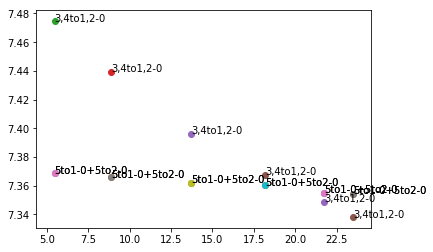

In [26]:
%matplotlib inline
selTr = [1,2,3]
R.pltTrLevel(selTr,excitations,Data,numOrb,True)

Transitions energies can be also plotted specifying the values of the transition labels

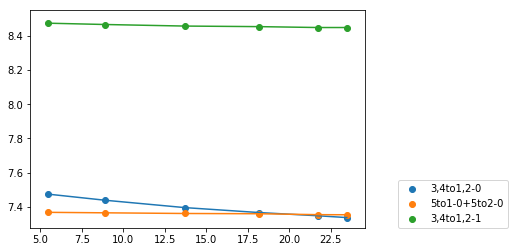

In [27]:
reload(R)
selLab = ['3,4to1,2-0','5to1-0+5to2-0','3,4to1,2-1']#,'3,4to1,2-3+3,4to1,2-4']
R.pltTrLabel(selLab,excitations,Data,numOrb,True)

COMMENTS :

* We observe that the energy of all the excitations (that for the lower values involve only Siegert states) change in function of the number of virtual states. In particular, the excitation 34to12 becomes the lowest energy one when the highest energy accessible by th virtual states is about 22eV. This value is realized with a different number of virtual states for rmult=7.0 and rmult=9.0 due to the collapse of the continuum. 
* Some (very few) excitations are very stable function of the number of virtual orbitals. 

### Analysis of the someOverThreshold parameter

In the previous section we have analyzed the excitations by looking the dependence of their energy in function of the number of virtual orbitals considered (or equivalently in function on the maximum energy accessible by the considered set of virtual orbitals)

Now we perform an analysis that takes into account the structure of the eigenvectors of the excitations. In particular we can introduce a "sumOverThreshold" parameter defined as follows:
* For each excitation we can identify the components of the $p\times\alpha$ eigenvectors that link a particular $p$ or $alpha$ orbitals to all the others. These quantities, deonoted as weightP or weightAlpha, represent a measurement of the contribution of the selected orbital to the excitation. 

The structure of the excitations evidence that the weights possess some (usually one or two) elements that are higly more important than the others, and this elements are used to label the particular excitation. We consider the weightAlpha (that is naturally normalized to 1) and we define the sumOverThreshold by summing the (square) of the weight of the more relevant virtual orbitals. This quantity is very close to 1, and we measure its discrepancy with respect to the unit. So we define a routine that computes:
$$
sot = 1 -\sum_{\alpha \,in \, more \, relevant \, orbitals} coeff(\alpha)^2 = 
\sum_{\alpha \,in \, less \, relevant \, orbitals} coeff(\alpha)^2
$$

Obviously this parameter depends on the number of virtual orbitals, so it is interesting to analyze both its value and its stability with respect to the virtual orbitals.

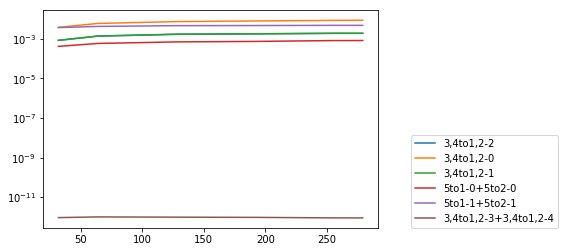

In [28]:
reload(R)
selLab = allTr[0:6]#['3,4to1,2-0','5to1-0+5to2-0','3,4to1,2-3+3,4to1,2-4']
sot = R.sotPlot(selLab,excitations)

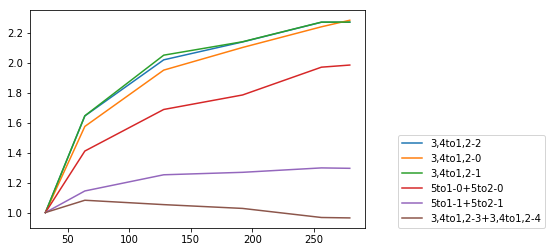

In [29]:
R.sotPlotNorm(sot)

COMMENTS: 
* The excitations '3,4to1,2-3+3,4to1,2-4' that is stable in energy has a very low values of sot 
* ...

### Analysis of the weights

We plot the weights of coefficients (below the threshold) of expansion of a given excitation (specified by its label) on the alpha states

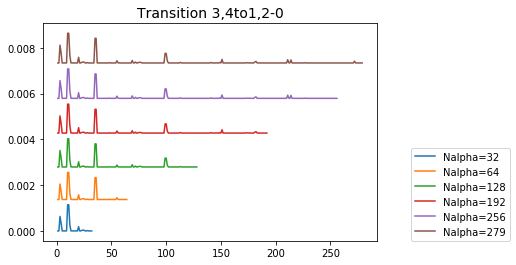

In [30]:
reload(R)
%matplotlib inline
selexc = '3,4to1,2-0' #'3,4to1,2-3+3,4to1,2-4'
R.weightAlphaPlot(selexc,excitations,Data,numOrb,False)

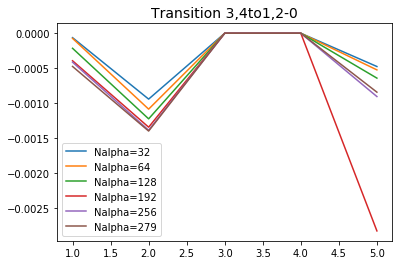

In [31]:
selexc = '3,4to1,2-0' #'5to2-0+5to1-0'
offs = 0.0
for na, e in excitations.iteritems():
    if selexc in e['transitions'].keys():
        p = np.linspace(1,numOrb,numOrb)
        wCut = -R.weightCut(e['transitions'][selexc]['weightP'])
        plt.plot(p,offs+wCut, label = 'Nalpha='+str(na))
        #offs+=1.2*max(abs(wCut)) 
plt.title('Transition '+selexc, fontsize = 14)
plt.legend()
plt.show()    

## Analysis of the oscillator strength

We plot the oscillator strenght for all the transitions (in function of their energy) using the maximum value of number of virtual orbitals

In [32]:
oscStrenght = []
na = excitations.keys()[-1]
for tr in allTr:
    oscStrenght.append(excitations[na]['transitions'][tr]['oscStrenght'])

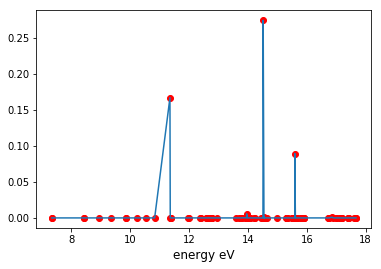

In [33]:
plt.plot(trEnergy,oscStrenght,'ro')
plt.plot(trEnergy,oscStrenght)
plt.xlabel('energy eV', size=12)
plt.show()

the same plot in function of the number of transitions

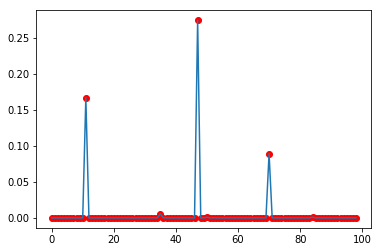

In [34]:
plt.plot(oscStrenght,'ro')
plt.plot(oscStrenght)
plt.show()

In [35]:
trOsc = []
trOscVal = []
for ind, os in enumerate(oscStrenght):
    if os > 0.01:
        trOsc.append(allTr[ind])
        trOscVal.append(os)
print trOsc
print trOscVal
trOscVal =np.array(trOscVal)
sortind = np.argsort(trOscVal)[::-1]
print sortind
trOsc = [trOsc[s] for s in sortind]
trOscVal = [trOscVal[s] for s in sortind]

print trOsc
print trOscVal

['5to4-0', '2,5to4,22-1', '3,4to18,19-6+3,4to18,19-7']
[0.16684251889565177, 0.27415810749096609, 0.08930714848272972]
[1 0 2]
['2,5to4,22-1', '5to4-0', '3,4to18,19-6+3,4to18,19-7']
[0.27415810749096609, 0.16684251889565177, 0.08930714848272972]


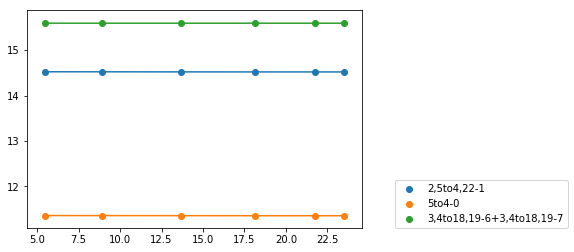

In [36]:
R.pltTrLabel(trOsc,excitations,Data,numOrb,True)

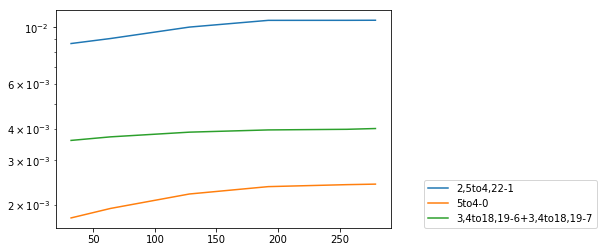

In [37]:
sot = R.sotPlot(trOsc,excitations)

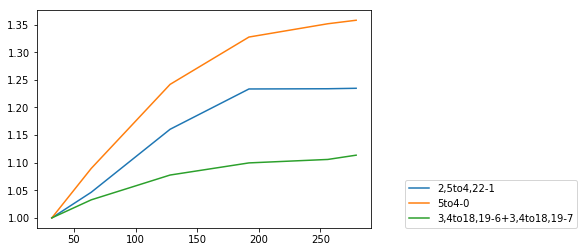

In [38]:
R.sotPlotNorm(sot)

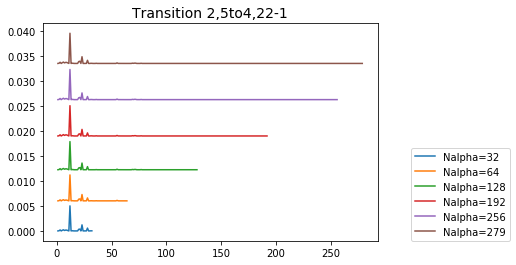

In [39]:
R.weightAlphaPlot(trOsc[0],excitations,Data,numOrb,False)

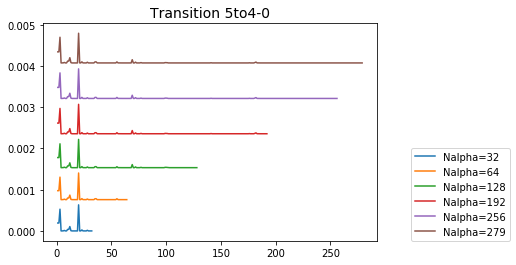

In [40]:
R.weightAlphaPlot(trOsc[1],excitations,Data,numOrb,False)

## Save reduced dictionary on file

In [41]:
exc = {}
for na,e in excitations.iteritems():
    transitions = {}
    for ind,v in e['transitions'].iteritems():
        transitions[ind] = {'weightP' : v['weightP'].tolist(),'weightAlpha' : v['weightAlpha'].tolist(),'level' : v['level'], 'eng' : v['eng'].tolist(), 'oscStrenght' : v['oscStrenght'].tolist()}
    exc[na] = {'transitions' : transitions}

In [42]:
filename = outputpath+'log/excitations_rmult'+str(rmult)+'.yaml '
Yaml.dump(exc,filename)